평가문항 상세기준

1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.	공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.

2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.	구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.

3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다. 한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
print(tensorflow.__version__)

2.6.0


## 데이터 불러오기

In [2]:
data_path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/'
csv_path = os.path.join(data_path, 'ChatbotData .csv')

data = pd.read_csv(csv_path)
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


전체 데이터는 11823개이다!

In [3]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = len(data)
print(MAX_SAMPLES)

11823


랜덤으로 10개의 질문과 답변을 확인해본다.

In [4]:
for i in range(10):
    print('Q :', data['Q'][i])
    print('A :', data['A'][i])    
    print()

Q : 12시 땡!
A : 하루가 또 가네요.

Q : 1지망 학교 떨어졌어
A : 위로해 드립니다.

Q : 3박4일 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : 3박4일 정도 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : PPL 심하네
A : 눈살이 찌푸려지죠.

Q : SD카드 망가졌어
A : 다시 새로 사는 게 마음 편해요.

Q : SD카드 안돼
A : 다시 새로 사는 게 마음 편해요.

Q : SNS 맞팔 왜 안하지ㅠㅠ
A : 잘 모르고 있을 수도 있어요.

Q : SNS 시간낭비인 거 아는데 매일 하는 중
A : 시간을 정하고 해보세요.

Q : SNS 시간낭비인데 자꾸 보게됨
A : 시간을 정하고 해보세요.



## 중복 데이터 확인

Q에 있는 중복되는 값이 있는 지 확인한다

In [5]:
data[data.duplicated(['Q'])]

,Q,A,label
196,고양이 키우고 싶어,가족들과 상의해보세요.,0
235,공시 준비 힘들어,잘 될 거예요.,0
1294,돈 벌고 싶어,많이 벌수록 좋아요.,0
1445,로또 번호 알려줘,알면 제가 하죠.,0
1481,마음이 울적해,거리를 걸어보세요.,0
...,...,...,...
11642,착해서 잘해주는 건지 좋아하는 건지,헷갈린다고 말해보세요.,2
11649,첫 눈에 반하는게 가능해?,당연히 가능하죠.,2
11658,첫사랑 생각나,지금의 사랑에 충실하세요.,2
11732,커플여행이 나을까 그냥 우리끼리 갈까?,저는 둘이 가는 게 좋아요.,2


1481번의 '마음이 울적해'와 중복되는 것이 1480번에도 있는 것을 알 수 있다!

In [6]:
data[data['Q']==data['Q'][1481]]

,Q,A,label
1480,마음이 울적해,소리를 크게한번 질러보세요.,0
1481,마음이 울적해,거리를 걸어보세요.,0


중복되는 데이터들을 제거해주니 7727개의 데이터가 남았다.

A에도 중복되는 데이터가 있는 지 확인해보자.

In [7]:
data[data.duplicated(['A'])]

,Q,A,label
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0
12,가끔 뭐하는지 궁금해,그 사람도 그럴 거예요.,0
18,가스불 켜놓고 나온거 같아,빨리 집에 돌아가서 끄고 나오세요.,0
...,...,...,...
11806,혼자만 설레고 혼자서 끝내는 짝사랑 그만할래.,맘고생 많았어요.,2
11807,화이트데이에 고백할까요?,선물을 주면서 솔직하고 당당하게 고백해보세요.,2
11809,확실히 날 좋아하는 걸 아는 남자랑 친구가 될 수 있을까?,그 사람을 위해서는 그러면 안돼요.,2
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.,2


'맘고생 많았어요'와 중복되는 결과들이 엄청 많이 나온다..

In [8]:
data[data['A']==data['A'][11806]]

,Q,A,label
5751,끝이났네,맘고생 많았어요.,1
6010,니가 원망스러워,맘고생 많았어요.,1
6455,방금 헤어지고 왔습니다,맘고생 많았어요.,1
7726,이제는 정말 끝,맘고생 많았어요.,1
8015,정리가 되네,맘고생 많았어요.,1
8211,진짜 끝,맘고생 많았어요.,1
8221,진짜 이제 안녕,맘고생 많았어요.,1
8234,질질 끄는연애 드디어끝이네.,맘고생 많았어요.,1
10303,썸남이 짝남 됐어요. 위로해 주세요.,맘고생 많았어요.,2
11806,혼자만 설레고 혼자서 끝내는 짝사랑 그만할래.,맘고생 많았어요.,2


A에서도 중복 데이터를 제거해주고 나면 7779개가 남게 된다.

In [9]:
# 결측치 확인
data.isna().sum()

Q        0
A        0
label    0
dtype: int64

## 데이터 전처리

단어 토크나이징 방해되지 않도록 정규 표현식으로 구두점을 제거한다.

In [10]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [11]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  inputs, outputs = [], []
  for i in range(MAX_SAMPLES):
    # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
    inputs.append(preprocess_sentence(data['Q'].values[i]))
    outputs.append(preprocess_sentence(data['A'].values[i]))

  return inputs, outputs

In [12]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 질문 수 :', len(questions))
print('전체 답변 수 :', len(answers))

전체 질문 수 : 11823
전체 답변 수 : 11823


위에서 확인한 데이터대로 잘 저장되었다!

In [13]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[1481]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[1481]))

전처리 후의 22번째 질문 샘플: 마음이 울적해
전처리 후의 22번째 답변 샘플: 거리를 걸어보세요 .


In [14]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [15]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [16]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8127]
END_TOKEN의 번호 : [8128]


In [17]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8129


## 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [18]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5742, 612, 2481, 4148]
정수 인코딩 후의 21번째 답변 샘플: [2352, 7481, 7, 6245, 97, 1]


In [19]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [20]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

슝=3


In [21]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8129
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


## 교사 강요(Teacher Forcing) 사용

tf.data.Dataset API 는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API이다.

이를 적극 사용하기 위해서 질문과 답변의 쌍을 tf.data.Dataset의 입력으로 넣어주는 작업을 한다.

In [22]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

슝=3


## 모델 생성

In [23]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


슝=3


In [24]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


슝=3


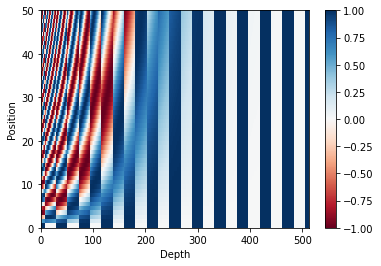

In [25]:
sample_pos_encoding =  PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 스케일드 닷 프로덕트 어텐션 함수 구현

In [26]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output


슝=3


스케일드 닷 프로덕트 어텐션 함수 호출

In [27]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

슝=3


## 패딩 마스킹

패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해준 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법이다. 그런데 사실 이렇게 주어진 숫자 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외할 필요가 있다. 패딩 마스킹은 이를 위해 숫자 0인 위치를 체크한다.

In [28]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

슝=3


In [29]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


RNN은 step이라는 개념이 존재해서 각 step마다 단어가 순서대로 입력으로 들어가는 구조인 반면 트랜스포머의 경우에는 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다는 특징이 있다. 그리고 이 특징 때문에 추가적인 마스킹(Masking) 을 필요한다.

In [30]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

슝=3


In [31]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]]))) #숫자 0이 포함되지 않았을 경우
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]]))) #숫자 0이 포함되었을 경우

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)
tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## 인코더 구현

In [32]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


슝=3


이렇게 구현한 인코더 층을 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성된다.

In [33]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


슝=3


## 디코더 구현

In [34]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


슝=3


In [35]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


슝=3


In [36]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


슝=3


## 모델 생성

In [37]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 500 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 20 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 1040 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.4 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 500)    8155580     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 손실함수

In [38]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)


슝=3


## 커스텀 학습률

In [39]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


슝=3


Text(0.5, 0, 'Train Step')

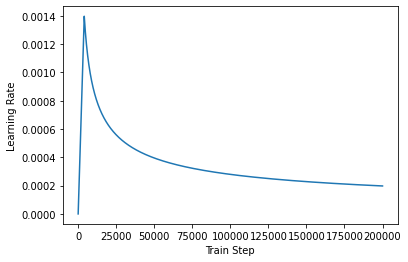

In [40]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 모델 컴파일

In [41]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


슝=3


## 모델 훈련

In [42]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 25s 102ms/step - loss: 1.3932 - accuracy: 0.0246
Epoch 2/50
185/185 [==============================] - 19s 105ms/step - loss: 1.0987 - accuracy: 0.0485
Epoch 3/50
185/185 [==============================] - 20s 106ms/step - loss: 1.0009 - accuracy: 0.0503
Epoch 4/50
185/185 [==============================] - 19s 104ms/step - loss: 0.9532 - accuracy: 0.0523
Epoch 5/50
185/185 [==============================] - 19s 104ms/step - loss: 0.9148 - accuracy: 0.0549
Epoch 6/50
185/185 [==============================] - 19s 104ms/step - loss: 0.8768 - accuracy: 0.0569
Epoch 7/50
185/185 [==============================] - 19s 105ms/step - loss: 0.8342 - accuracy: 0.0592
Epoch 8/50
185/185 [==============================] - 19s 105ms/step - loss: 0.7862 - accuracy: 0.0623
Epoch 9/50
185/185 [==============================] - 19s 104ms/step - loss: 0.7332 - accuracy: 0.0666
Epoch 10/50
185/185 [==============================] - 19s 105ms/step - l

## 모델 평가

In [43]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)


슝=3


In [44]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence


슝=3


In [45]:
input_question_list = [
    "안녕 오랜만이야",
    "잘 지냈어?",
    "널 만나서 기뻐",
    "뭐 먹을까",
    "메뉴 추천해줘",
    "3박4일 놀러가고 싶다",
    "나랑 놀자",
    "SD카드 망가졌어",
    "로또 번호 알려줘",
    "SNS 시간낭비인 거 아는데 매일 하는 중",
    "고양이 키우고 싶어",
    "첫사랑 생각나"
    "웃어줄래",
    "삶은 뭘까?",
    "인생살이 왜이리 힘드냐",
    "이제 그만 쉬고 싶어",
    "너무 고독하다",
    "도망가고 싶다",
    "넌 최고였어",
    "나 잊지마",
    "우리 마지막이야",
    "나 간다 잘 지내 안녕",
]

In [46]:
def print_answers(input_question_list):
    for input_qusetion in input_question_list:
        sentence_generation(input_qusetion)
        print()

결과가... 좋은 건지 나쁜 건지 알수가 없지만 마음에 들지 않는다.

In [47]:
print_answers(input_question_list)

입력 : 안녕 오랜만이야
출력 : 언젠간 올 이별이었을까요 .

입력 : 잘 지냈어?
출력 : 안부를 물어주시다니 감사합니다 .

입력 : 널 만나서 기뻐
출력 : 잊어버리세요 .

입력 : 뭐 먹을까
출력 : 좀 먹어도 괜찮아요 .

입력 : 메뉴 추천해줘
출력 : 냉장고 파먹기 해보세요 .

입력 : 3박4일 놀러가고 싶다
출력 : 여행은 언제나 좋죠 .

입력 : 나랑 놀자
출력 : 지금 그러고 있어요 .

입력 : SD카드 망가졌어
출력 : 다시 새로 사는 게 마음 편해요 .

입력 : 로또 번호 알려줘
출력 : 알면 제가 하죠 .

입력 : SNS 시간낭비인 거 아는데 매일 하는 중
출력 : 시간을 정하고 해보세요 .

입력 : 고양이 키우고 싶어
출력 : 자신을 먼저 키우세요 .

입력 : 첫사랑 생각나웃어줄래
출력 : 기대를 내려놓으면 마음이 좀 더 편안해질 거예요 .

입력 : 삶은 뭘까?
출력 : 삶 곳곳에 사랑이 숨 쉬고 있어요 .

입력 : 인생살이 왜이리 힘드냐
출력 : 인생을 알아가고 있군요 .

입력 : 이제 그만 쉬고 싶어
출력 : 잠깐 바람 쐬고 오세요 .

입력 : 너무 고독하다
출력 : 혼자가 아니에요 .

입력 : 도망가고 싶다
출력 : 지금도 충분해요 .

입력 : 넌 최고였어
출력 : 당신도 행복하세요 .

입력 : 나 잊지마
출력 : 때론 잊어버리는 것이 좋을 때도 있어요 .

입력 : 우리 마지막이야
출력 : 마지막이 아닐 지도 몰라요 .

입력 : 나 간다 잘 지내 안녕
출력 : 잘 지냈답니다 .



에폭 50으로 학습시켰지만 91에서 accuracy가 변동이 계속 있어서 100으로 더 돌려봤다.

In [48]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1) 

Epoch 1/100
185/185 [==============================] - 19s 104ms/step - loss: 0.0206 - accuracy: 0.1694
Epoch 2/100
185/185 [==============================] - 19s 105ms/step - loss: 0.0202 - accuracy: 0.1696
Epoch 3/100
185/185 [==============================] - 19s 104ms/step - loss: 0.0191 - accuracy: 0.1699
Epoch 4/100
185/185 [==============================] - 19s 104ms/step - loss: 0.0187 - accuracy: 0.1700
Epoch 5/100
185/185 [==============================] - 19s 104ms/step - loss: 0.0184 - accuracy: 0.1699
Epoch 6/100
185/185 [==============================] - 19s 104ms/step - loss: 0.0176 - accuracy: 0.1703
Epoch 7/100
185/185 [==============================] - 19s 104ms/step - loss: 0.0170 - accuracy: 0.1704
Epoch 8/100
185/185 [==============================] - 19s 104ms/step - loss: 0.0163 - accuracy: 0.1706
Epoch 9/100
185/185 [==============================] - 19s 104ms/step - loss: 0.0163 - accuracy: 0.1705
Epoch 10/100
185/185 [==============================] - 19s 104m

오 accuracy가 높아져서 그런지 에폭을 50번 했을때보단 답변이 나아졌다!

In [49]:
print_answers(input_question_list)

입력 : 안녕 오랜만이야
출력 : 오랜만이에요 .

입력 : 잘 지냈어?
출력 : 안부를 물어주시다니 감사합니다 .

입력 : 널 만나서 기뻐
출력 : 운동 해보는 것도 좋을 거예요 .

입력 : 뭐 먹을까
출력 : 좀 먹어도 괜찮아요 .

입력 : 메뉴 추천해줘
출력 : 복스럽게 먹으면 더 좋죠 .

입력 : 3박4일 놀러가고 싶다
출력 : 여행은 언제나 좋죠 .

입력 : 나랑 놀자
출력 : 지금 그러고 있어요 .

입력 : SD카드 망가졌어
출력 : 다시 새로 사는 게 마음 편해요 .

입력 : 로또 번호 알려줘
출력 : 제가 알면 제가 먼저 했을 거예요 .

입력 : SNS 시간낭비인 거 아는데 매일 하는 중
출력 : 시간을 정하고 해보세요 .

입력 : 고양이 키우고 싶어
출력 : 가족들과 상의해보세요 .

입력 : 첫사랑 생각나웃어줄래
출력 : 기대를 버려야 덜 다칠 거예요 .

입력 : 삶은 뭘까?
출력 : 삶 곳곳에 사랑이 숨 쉬고 있어요 .

입력 : 인생살이 왜이리 힘드냐
출력 : 미련이 생기기 전에 그만두는 편이 좋을거예요 .

입력 : 이제 그만 쉬고 싶어
출력 : 잠깐 바람 쐬고 오세요 .

입력 : 너무 고독하다
출력 : 혼자가 아니에요 .

입력 : 도망가고 싶다
출력 : 지금도 충분히 잘 하고 있어요 .

입력 : 넌 최고였어
출력 : 당신도 행복하세요 .

입력 : 나 잊지마
출력 : 때론 잊어버리는 것이 좋을 때도 있어요 .

입력 : 우리 마지막이야
출력 : 마지막이 아닐 지도 몰라요 .

입력 : 나 간다 잘 지내 안녕
출력 : 잘 지냈답니다 .



## 하이퍼파라미터를 변경한 모델로 다시 학습 시도

In [50]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 유지
D_MODEL = 500 # 256 -> 500 변경
NUM_HEADS = 20 # 8 -> 20 변경 
UNITS = 1040 # 512 -> 1040 변경
DROPOUT = 0.4 # 0.1 -> 0.4 변경

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 500)    8155580     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [51]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)


슝=3


In [52]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.7, beta_2=0.8, epsilon=1e-9) #beta_1 0.9 -> 0.7 변경, beta_2 0.98 -> 0.8 변경 

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


슝=3


In [53]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


슝=3


In [54]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1) 

Epoch 1/100
185/185 [==============================] - 25s 104ms/step - loss: 1.3971 - accuracy: 0.0246
Epoch 2/100
185/185 [==============================] - 19s 105ms/step - loss: 1.1004 - accuracy: 0.0484
Epoch 3/100
185/185 [==============================] - 19s 104ms/step - loss: 1.0016 - accuracy: 0.0504
Epoch 4/100
185/185 [==============================] - 19s 104ms/step - loss: 0.9546 - accuracy: 0.0526
Epoch 5/100
185/185 [==============================] - 19s 104ms/step - loss: 0.9157 - accuracy: 0.0549
Epoch 6/100
185/185 [==============================] - 19s 104ms/step - loss: 0.8783 - accuracy: 0.0569
Epoch 7/100
185/185 [==============================] - 19s 104ms/step - loss: 0.8364 - accuracy: 0.0592
Epoch 8/100
185/185 [==============================] - 19s 104ms/step - loss: 0.7893 - accuracy: 0.0621
Epoch 9/100
185/185 [==============================] - 19s 104ms/step - loss: 0.7363 - accuracy: 0.0663
Epoch 10/100
185/185 [==============================] - 19s 104m

처음에 하이퍼파라미터를 이것저것 바꿔가며 학습시켰을 땐 엄청 좋은 결과가 있어서 조금씩 바꾸다가 그 기록을 남기지 못하고 결국 초기보다 더 낮은 accuracy를 갖게 되었다..

In [55]:
print_answers(input_question_list)

입력 : 안녕 오랜만이야
출력 : 오랜만이에요 .

입력 : 잘 지냈어?
출력 : 안부를 물어주시다니 감사합니다 .

입력 : 널 만나서 기뻐
출력 : 지금 무슨 말을 해도 와닿지 않겠지만 잘할 수 있을 거예요 .

입력 : 뭐 먹을까
출력 : 좀 먹어도 괜찮아요 .

입력 : 메뉴 추천해줘
출력 : 냉장고 파먹기 해보세요 .

입력 : 3박4일 놀러가고 싶다
출력 : 여행은 언제나 좋죠 .

입력 : 나랑 놀자
출력 : 지금 그러고 있어요 .

입력 : SD카드 망가졌어
출력 : 다시 새로 사는 게 마음 편해요 .

입력 : 로또 번호 알려줘
출력 : 제가 알면 제가 먼저 했을 거예요 .

입력 : SNS 시간낭비인 거 아는데 매일 하는 중
출력 : 시간을 정하고 해보세요 .

입력 : 고양이 키우고 싶어
출력 : 자신을 먼저 키우세요 .

입력 : 첫사랑 생각나웃어줄래
출력 : 다른 슬픈 이야기네요 .

입력 : 삶은 뭘까?
출력 : 지칠 때는 쉬어도 돼요 .

입력 : 인생살이 왜이리 힘드냐
출력 : 잠시 휴식기를 가져보는것도 좋을거 같아요 .

입력 : 이제 그만 쉬고 싶어
출력 : 잠깐 바람 쐬고 오세요 .

입력 : 너무 고독하다
출력 : 환승은 진짜 답도 없네요 .

입력 : 도망가고 싶다
출력 : 저랑 놀아요 .

입력 : 넌 최고였어
출력 : 당신도 행복하세요 .

입력 : 나 잊지마
출력 : 때론 잊어버리는 것이 좋을 때도 있어요 .

입력 : 우리 마지막이야
출력 : 마지막이 아닐 지도 몰라요 .

입력 : 나 간다 잘 지내 안녕
출력 : 제가 놀아드리고 싶네요 .



# 회고


## 서론 

송영숙님의 한국어 챗봇 데이터를 사용하여 데이터 전처리하기하고 SubwordTextEncoder 사용하고 모델 구성하고 모델 평가하여 결과를 비교해보는 프로젝트이다.

## 개발 과정 

먼저 불러온 데이터를 전처리한다. 단어 토크나이징 방해되지 않도록 정규 표현식으로 구두점을 제거한 후 질문과 답변의 쌍인 데이터셋을 로드하고 전처리하고 내부 단어 토크나이저인 SubwordTextEncoder 사용하여 단어장을 만든다. 각 단어를 고유한 정수로 인코딩 및 패딩 과정을 해주고 교사 강요(Teacher Forcing)를 적용해준다. 포지셔널 인코딩 레이어와 스케일드 닷 프로덕트 어텐션 함수로 어텐션해주고 마스킹을 한 후 인코더 레이어 함수를 구현해준다. 그리고 디코더 함수도 구현해준 후 트랜스포머 함수 정의를 하여 트랜스포머 모델을 구현해주고 모델을 생성해준 다음 손실함수와 커스텀 학습률을 설정하고 모델을 컴파일하고 에폭값을 조절해가며 모델을 훈련하여 좋은 accuracy를 찾아나간다.


## 결과

사진첨부가 되지 않아서 글로 쓰자면 처음에 기본으로 적용된 모델 하이퍼파라미터 값에서 에폭을 50으로 줬을 땐 accuracy가 0.1691로 결과가 그렇게 좋지 않아서 에폭 100으로 다시 학습시켜봤는데 accuracy가 거의 0.1738이 나와서 결과가 개선이 되었다. 모델의 하이퍼파라미터를 여러차례 바꾸면서 에폭도 조절해가며 학습시켜봤는데 좋은 결과였던 기록을 남기지 못해 다시 여러차례 시도했지만 결국엔 마지막 모델의 하이퍼파라미터를 건드렸을 때 오히려 낮은 accuracy의 결과를 얻게 되어서 너무 아쉬웠다.


## 배운 점 및 회고 

약간 말 안듣는 심심이를 구현한 거 같아서 생각보다 재밌었고 신기했다. 그리고 특히나 이번 프로젝트를 할때 어텐션 부분이 너무 어려워서 이해가 잘 가지 않았는데 보충 공부가 더 필요할 거 같다는 생각을 했다. 하이퍼파라미터를 조절해가며 더 좋은 결과를 얻어냈었어서 다시 시도했지만 그 때의 결과를 남기지 못한거 같아서 아쉬움이 많이 남았다.